In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin, pi, sqrt
import tqdm
from scipy.fft import fft, fftfreq

In [2]:
def Esolver(larmor, hyp_dn, hyp_up):
    Azz = (hyp_up**2 - hyp_dn**2)/(4*larmor)
    Azx = np.sqrt(hyp_up**2-(larmor+Azz)**2)
    return [Azz,Azx]
x = Esolver(65.95, 59.95, 123.9)
print('Azz = {} kHz'.format(x[0])+' and Azx = {} kHz'.format(x[1]))
print('omega_up={}'.format(sqrt((65.95+x[0])**2+x[1]**2))+' omega_dn={}'.format(sqrt((65.95-x[0])**2+x[1]**2)))


Azz = 44.56864101592115 kHz and Azx = 56.00749939065258 kHz
omega_up=123.9 omega_dn=59.94999999999999


In [3]:
def anal_eseem_spin_lr(fL, Azz, Azx, tau1, tau2, tc): ## Azz and Azx are np.array
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_b = 2*pi*np.sqrt((FL-Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_plus = Ome_a + Ome_a
    Ome_minu = Ome_b - Ome_b
    Eta_a = np.arctan((Azx)/(fL+Azz))     ## specific for spin 1/2
    Eta_b = np.arctan((-Azx)/(fL-Azz))    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    term1 = 1
    term2 = 1
    term3 = 1
    term4 = 1
    for i, azz in enumerate(Azz):
        E_2p_tau1 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau1) +cos(Ome_b[i]*tau1) 
                                  -0.5*cos(Ome_minu[i]*tau1) -0.5*cos(Ome_plus[i]*tau1))
        E_2p_tau2 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau2) +cos(Ome_b[i]*tau2) 
                                  -0.5*cos(Ome_minu[i]*tau2) -0.5*cos(Ome_plus[i]*tau2))

        term1 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term2 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term3 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) ) 
        
        term4 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) )
    
    
    signal = term1 - term2 + term3 -term4
    return [ signal, term1 , term2, term3, term4]

def anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=1): ## Azz and Azx are np.array, ms = 1 or -1
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+ms*Azz)**2+Azx**2) ## Here is the only place we assume spin 1
    Ome_b = 2*pi*FL                                ## Here is the only place we assume spin 1
    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan((ms*Azx)/(fL+ms*Azz))   ## specific for spin 1
    Eta_b = 0                                 ## specific for spin 1
    Eta = (Eta_a - Eta_b)/2        
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    term1 = 1
    term2 = 1
    term3 = 1
    term4 = 1
    for i, azz in enumerate(Azz):
        E_2p_tau1 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau1) +cos(Ome_b[i]*tau1) 
                                  -0.5*cos(Ome_minu[i]*tau1) -0.5*cos(Ome_plus[i]*tau1))
        E_2p_tau2 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau2) +cos(Ome_b[i]*tau2) 
                                  -0.5*cos(Ome_minu[i]*tau2) -0.5*cos(Ome_plus[i]*tau2))

        term1 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term2 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term3 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) ) 
        
        term4 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) )
    
    
    signal = term1 - term2 + term3 -term4
    return [signal, term1 , term2, term3, term4] 




In [17]:
%matplotlib notebook
# determining the parameters
fL = 63.2 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 85.51]) # kHz
Azx = np.array([64.4, 143.6, 120.11]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('Blind Spot up={} us'.format(BS_up*1000))
print('k_dn={} kHz'.format(k_dn))
print('k_up={} kHz'.format(k_up))

Freq Larmor=63.2 kHz
Azz=[204.   -51.5   85.51] kHz
Azx=[ 64.4  143.6  120.11] kHz
Freq hyp dn=[154.82893786 183.78533674 122.16443099] kHz
Freq hyp up=[274.85123249 144.07584808 191.15720285] kHz
Blind Spot dn=[6.45874094 5.44113049 8.18568868] us
Blind Spot up=[3.63833187 6.94078857 5.23129647] us
k_dn=[0.41594292 0.78134634 0.98318307] kHz
k_up=[0.23430857 0.99669724 0.62833102] kHz


Freq Larmor=63.0 kHz
Azz=[204.   -51.5   85.51] kHz
Azx=[ 64.4  143.6  120.11] kHz
Freq hyp up=[274.65680403 144.05974455 191.00165497] kHz
Freq hyp dn=[155.01083833 183.66058369 122.20111374] kHz
Blind Spot up=[3.64090744 6.94156444 5.23555673] us
Blind Spot dn=[6.45116181 5.44482643 8.18323147] us
k_up=[0.23447444 0.99680865 0.62884272] kHz
k_dn=[0.41545482 0.78187708 0.98288793] kHz


<IPython.core.display.Javascript object>


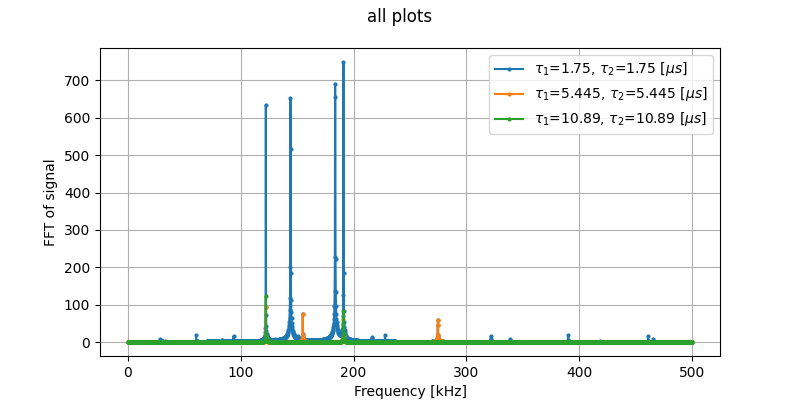

<ipython-input-18-d795f615beb1>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


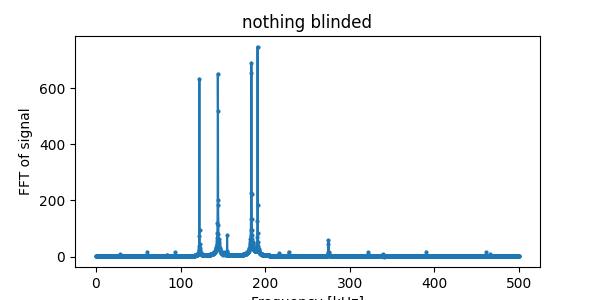

<ipython-input-18-d795f615beb1>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


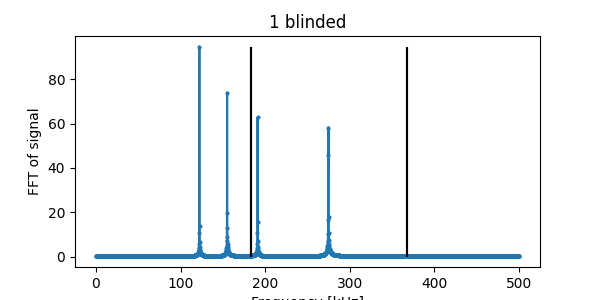

<ipython-input-18-d795f615beb1>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


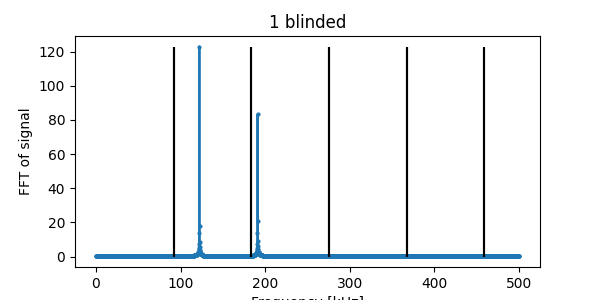

In [18]:
%matplotlib notebook
# determining the parameters
B = 63/1.07 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 85.51]) # kHz
Azx = np.array([64.4, 143.6, 120.11]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 5000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,1, figsize=(8, 4), dpi=100)

for tau1, tau2,txt in [[1.75e-3, 1.75e-3, 'nothing blinded'],[1*BS_dn[1], 1*BS_dn[1], '1 blinded']
                      ,[2*BS_dn[1], 2*BS_dn[1], '1 blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm.tqdm_notebook(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_lr(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,1, figsize=(6, 3),dpi=100)
    ax.set_title(txt)
    ax.plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1 <np.max(freqs):ax.vlines(x=i/tau1,ymin=0,ymax=max(FFT_Signal),color='black')
        if i/tau2 <np.max(freqs):ax.vlines(x=i/tau2,ymin=0,ymax=max(FFT_Signal),color='black')
    ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    



fig_all.suptitle('all plots')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend(loc='upper right')
ax_all.grid()

# Let's go to higher number of pulses

In [19]:
#
from qutip import *
from numpy import real, cos, sin, exp, linspace,arccos, array, sqrt,pi
width = 3.45 #W
height = width #H (Or golden ratio)
import numpy as np
#The preamble of the text is:
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 2.5, "ytick.major.size": 0, "xtick.direction": "in"})

cmap = sns.color_palette(n_colors=10)
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
import tqdm
from scipy.fft import fft, fftfreq

#
Iz = 0.5*sigmaz()
Ix = 0.5*sigmax()
Iy = 0.5*sigmay()
Ie = qeye(2)*0.5

In [20]:
def ESEEM_dd(azz, azx, tau1, tau2, Tc, N1=1, N2=1): 
    # N = number of pi pulses at each hahn-echo\ tau-2tau-2tau-tau-...
    H0 = (WL-azz)*Iz+azx*Ix # Specific to spin 1
    H1 = (WL+azz)*Iz+azx*Ix # Specific to spin 1
    
    Tau1 = np.arange(N1)*(2*tau1) + tau1 # timing of pi pulses in a string
    Tau1 = np.append(Tau1, N1*2*tau1) # the last point is the end of sequence (not a pi pulse): the last evolution
    Tau2 = np.arange(N2)*(2*tau2) + tau2 
    Tau2 = np.append(Tau2, N2*2*tau2) 
    
    
    for i, t in enumerate(Tau1):
        if i==0:
            U0 = (-1j*H0*tau1).expm()
            U1 = (-1j*H1*tau1).expm()
            continue
        u0 = (-1j*H0*(t-Tau1[i-1])).expm()
        u1 = (-1j*H1*(t-Tau1[i-1])).expm()
        if (i%2)==0:
            U0 *= u0
            U1 *= u1
        else:
            U0 *= u1
            U1 *= u0
    
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    
    for i, t in enumerate(Tau2):
        if i==0:
            V0 = (-1j*H0*tau2).expm()
            V1 = (-1j*H1*tau2).expm()
            continue
        v0 = (-1j*H0*(t-Tau2[i-1])).expm()
        v1 = (-1j*H1*(t-Tau2[i-1])).expm()
        if (i%2)==0:
            V0 *= v0
            V1 *= v1
        else:
            V0 *= v1
            V1 *= v0
            
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

def five_pulse_ESEEM(azz, azx, tau1, tau2, Tc, N=1): # N = number of pi pulses at each hahn-echo, tau-2tau-2tau-2tau-...
    H0 = (WL-azz)*Iz+azx*Ix # Specific to spin 1
    H1 = (WL+azz)*Iz+azx*Ix # Specific to spin 1
    u0 = ((-1j*H1*tau1).expm())*((-1j*H0*tau1).expm())
    u1 = ((-1j*H0*tau1).expm())*((-1j*H1*tau1).expm())
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    v0 = ((-1j*H1*tau2).expm())*((-1j*H0*tau2).expm())
    v1 = ((-1j*H0*tau2).expm())*((-1j*H1*tau2).expm())
    
    if N==1:
        tt1 = (v1*W0*u0*(u1.dag())*(W0.dag())*(v0.dag())).tr()
        tt2 = (v0*W0*u0*(u1.dag())*(W0.dag())*(v1.dag())).tr()
        tt3 = (v1*W1*u0*(u1.dag())*(W1.dag())*(v0.dag())).tr()
        tt4 = (v0*W1*u0*(u1.dag())*(W1.dag())*(v1.dag())).tr()
        return [tt1, tt2, tt3, tt4]
    else:
        U0 = (u0**(N%2)) * ((u1*u0)**(N//2))
        U1 = (u1**(N%2)) * ((u0*u1)**(N//2))
        V0 = (v0**(N%2)) * ((v1*v0)**(N//2))
        V1 = (v1**(N%2)) * ((v0*v1)**(N//2))
        tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
        tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
        tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
        tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
        return [tt1, tt2, tt3, tt4]

In [32]:

# determining the parameters
fL = 63.2 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 1,2,4,2]) # kHz
Azx = np.array([64.4, 143.6, 4,3,1,3]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k = (Azx*fL/(Fh_up*Fh_up))**2
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('Blind Spot up={} us'.format(BS_up*1000))
print('k={} kHz'.format(k))

Freq Larmor=63.2 kHz
Azz=[204.  -51.5   1.    2.    4.    2. ] kHz
Azx=[ 64.4 143.6   4.    3.    1.    3. ] kHz
Freq hyp dn=[154.82893786 183.78533674  62.32848466  61.27348529  59.20844534
  61.27348529] kHz
Freq hyp up=[274.85123249 144.07584808  64.32448989  65.26898191  67.20744006
  65.26898191] kHz
Blind Spot dn=[ 6.45874094  5.44113049 16.04402875 16.32027288 16.88948247 16.32027288] us
Blind Spot up=[ 3.63833187  6.94078857 15.54617847 15.3212134  14.87930502 15.3212134 ] us
k=[0.00290279 0.19115176 0.00373292 0.00198084 0.00019578 0.00198084] kHz


Freq Larmor=63.2 kHz
Azz=[204.  -51.5   1.    2.    4.    2. ] kHz
Azx=[ 64.4 143.6   4.    3.    1.    3. ] kHz
Freq hyp dn=[154.82893786 183.78533674  62.32848466  61.27348529  59.20844534
  61.27348529] kHz
Freq hyp up=[274.85123249 144.07584808  64.32448989  65.26898191  67.20744006
  65.26898191] kHz
Blind Spot dn=[ 6.45874094  5.44113049 16.04402875 16.32027288 16.88948247 16.32027288] us
Blind Spot up=[ 3.63833187  6.94078857 15.54617847 15.3212134  14.87930502 15.3212134 ] us
k=[0.00290279 0.19115176 0.00373292 0.00198084 0.00019578 0.00198084] kHz


<IPython.core.display.Javascript object>


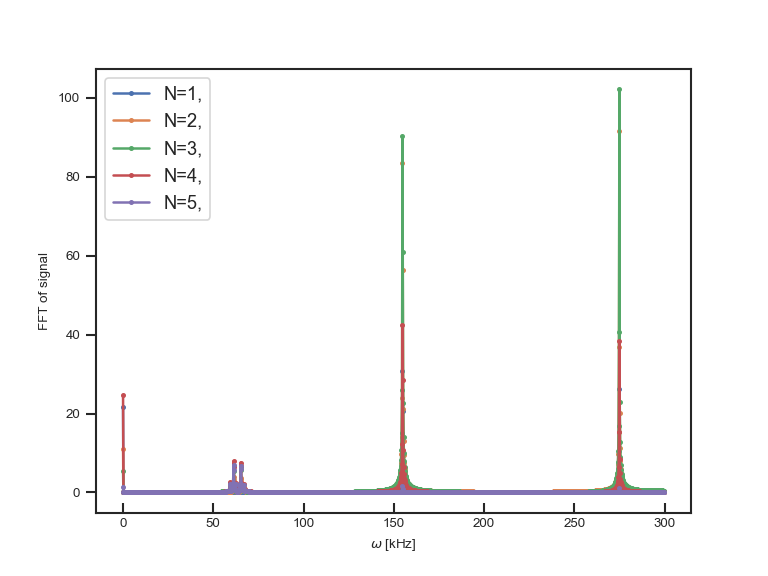

<ipython-input-33-69e365d1b784>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


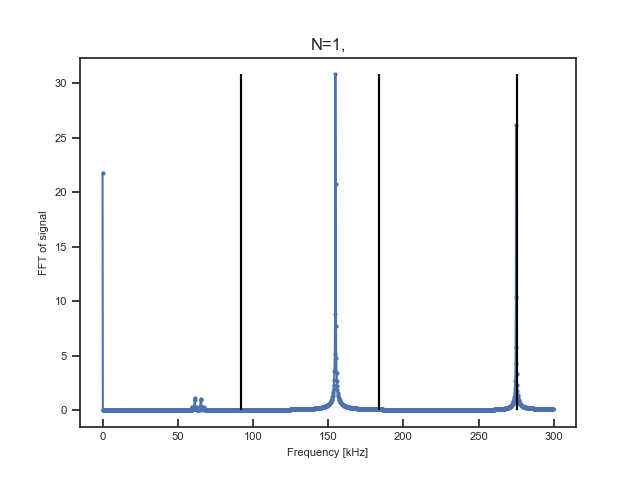

<ipython-input-33-69e365d1b784>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


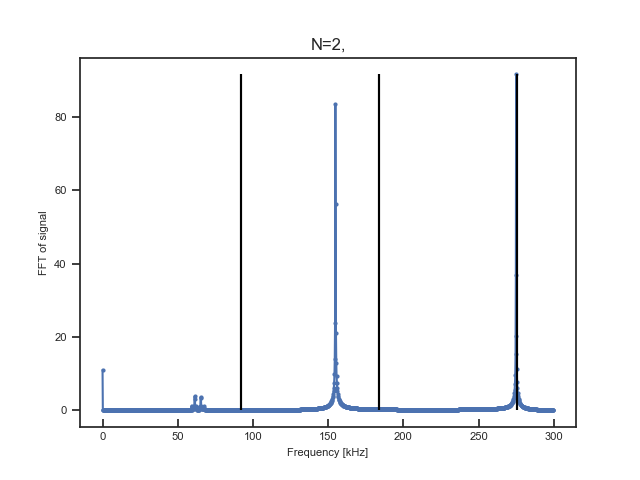

<ipython-input-33-69e365d1b784>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


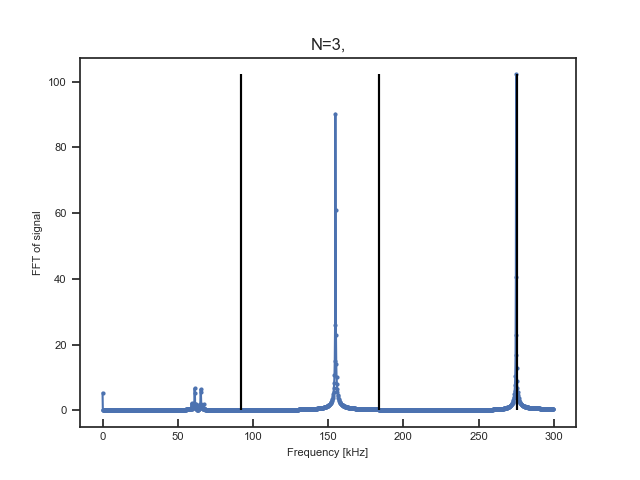

<ipython-input-33-69e365d1b784>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


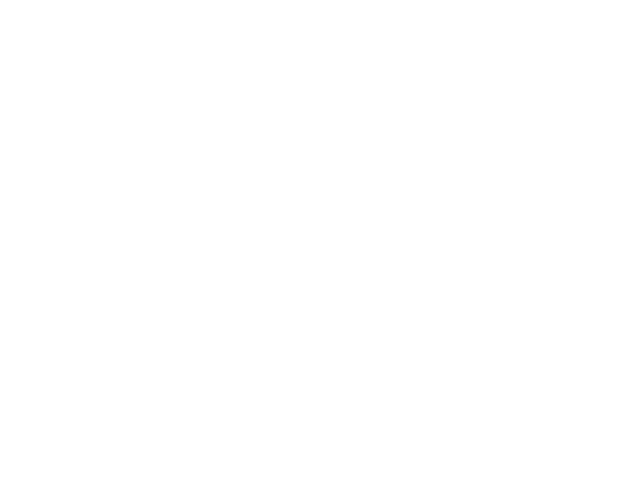

<ipython-input-33-69e365d1b784>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


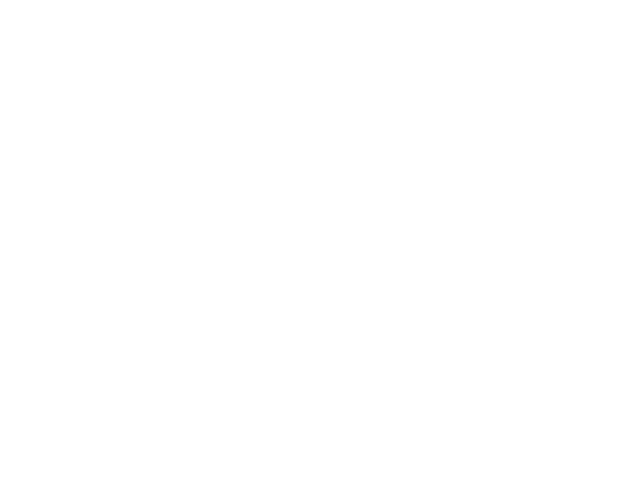

In [33]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('Blind Spot up={} us'.format(BS_up*1000))
print('k={} kHz'.format(k))

fig_all,ax_all = plt.subplots(dpi=120)
tau1, tau2 = BS_dn[1]*2, BS_dn[1]*2
for n in [1,2,3,4,5]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N=n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)
    
    freqs = fftfreq(steps, 1/sample_rate)[0:int(steps/2)]
    fft_signal = np.abs(fft(signal))[0:int(steps/2)]
    fig,ax = plt.subplots(dpi=100)
    ax.set_title(label='N={},'.format(n))
    ax.plot(freqs, fft_signal,'-o',markersize=2, alpha = 1)
    ax_all.plot(freqs, fft_signal,'-o',markersize=2, alpha=1, label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    for i in np.arange(1,100,1):
        if i/tau1 <np.max(freqs):ax.vlines(x=i/tau1,ymin=0,ymax=max(fft_signal),color='black')
        if i/tau2 <np.max(freqs):ax.vlines(x=i/tau2,ymin=0,ymax=max(fft_signal),color='black')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [30]:
# determining the parameters
fL = 63.2 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, -52.7, 1,2,1.5,2]) # kHz
Azx = np.array([64.4, 143.6, 38.9, 4,3,1,3]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k = (Azx*fL/(Fh_up*Fh_up))**2
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('Blind Spot up={} us'.format(BS_up*1000))
print('k={} kHz'.format(k))

Freq Larmor=63.2 kHz
Azz=[204.  -51.5 -52.7   1.    2.    1.5   2. ] kHz
Azx=[ 64.4 143.6  38.9   4.    3.    1.    3. ] kHz
Freq hyp dn=[154.82893786 183.78533674 122.25391609  62.32848466  61.27348529
  61.7081032   61.27348529] kHz
Freq hyp up=[274.85123249 144.07584808  40.29218286  64.32448989  65.26898191
  64.70772751  65.26898191] kHz
Blind Spot dn=[ 6.45874094  5.44113049  8.17969708 16.04402875 16.32027288 16.20532715
 16.32027288] us
Blind Spot up=[ 3.63833187  6.94078857 24.81870996 15.54617847 15.3212134  15.45410476
 15.3212134 ] us
k=[2.90278678e-03 1.91151759e-01 2.29324351e+00 3.73292046e-03
 1.98083961e-03 2.27829294e-04 1.98083961e-03] kHz


In [ ]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('Blind Spot up={} us'.format(BS_up*1000))
print('k={} kHz'.format(k))

fig_all,ax_all = plt.subplots(dpi=120)
n=4
for tau1,tau2 in [[1.75e=3,1.75e-3],[BS_dn[1], BS_up[0]],[BS_dn[1]*2, BS_dn[1]*2]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N=n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)
    
    freqs = fftfreq(steps, 1/sample_rate)[0:int(steps/2)]
    fft_signal = np.abs(fft(signal))[0:int(steps/2)]
    fig,ax = plt.subplots(dpi=100)
    ax.set_title(r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))))
    ax.plot(freqs, fft_signal,'-o',markersize=2, alpha = 1)
    ax_all.plot(freqs, fft_signal,'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-7*(round(tau1*1e7)))+r' $\tau_2$={} [$\mu s$]'.format(1e-7*(round(tau2*1e7))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    for i in np.arange(1,100,1):
        if i/tau1 <np.max(freqs):ax.vlines(x=i/tau1,ymin=0,ymax=max(fft_signal),color='black')
        if i/tau2 <np.max(freqs):ax.vlines(x=i/tau2,ymin=0,ymax=max(fft_signal),color='black')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()